# Results exporter
Notebook to easily load a sacred experiment and create a CSV file ready to be used in Latex.

In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs
import scipy.stats as sts

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))

Loaded runs: 572
Loaded final runs: 704


In [3]:
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))
mis_runs_local = load_runs('../sacred_mis/')
print("Loaded mis runs:", len(mis_runs_local.keys()))
# Merge the runs
total_runs = {}
for key, value in runs.items():
    total_runs[str(key) + '-base'] = value
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-local'] = value
for key, value in mis_runs_local.items():
    total_runs[str(key) + '-mis'] = value

Loaded pdisnn runs: 628
Loaded mis runs: 682


## Load the experiment we need

Experiments: 35
Seeds: 236, 963, 160, 570, 15, 545, 904, 10, 109, 10, 109, 307, 8, 178, 153, 950, 245, 10, 746, 712, 160, 904, 570, 570, 904, 109, 160, 315, 100, 481, 42, 662, 247, 947, 689


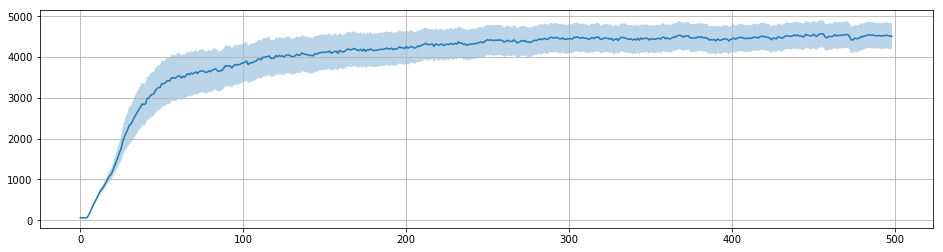

In [49]:
query = {
    'run.status': 'COMPLETED',
    #'config.center': False,
    'config.gamma': 1.0,
    #'config.clipping': False,
    #'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none',
    'config.entropy': 'none',
    'config.env': 'rllab.cartpole',
    'config.iw_method': 'is',
    #'config.delta': 0.9,
    'config.bound': 'max-d2-harmonic',
    'config.capacity': 5,
    'config.njobs': 10,
    'config.num_episodes': 100
}
filtered_runs = filter_runs(query, total_runs)
print("Experiments:", len(filtered_runs.keys()))
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.grid()
plt.show();

## Extract the data we need for the CSV

In [43]:
runs = list(filtered_runs.keys())
rewards, timesteps = [], []
for run_key in runs:
    # Get the iteration number, used as index
    iteration = filtered_runs[run_key]['metrics']['Iteration']['values']
    # Get the number of timesteps 
    timestep = filtered_runs[run_key]['metrics']['TimestepsSoFar']['values']
    # Get reward
    reward = filtered_runs[run_key]['metrics']['EpRewMean']['values']
    rewards.append(pd.Series(reward, iteration))
    timesteps.append(pd.Series(timestep, iteration))
    # Plot IW std
    #stdiw_pdis = filtered_runs[run_key]['metrics']['StdIW_mean']['values']
    #stdiw_is = filtered_runs[run_key]['metrics']['IS_StdIW']['values']
    #ratio = (np.array(stdiw_is) - np.array(stdiw_pdis)) / np.abs(np.array(stdiw_pdis))
    #df.append(pd.Series(ratio, episodes))
    
    # Plot J std
    #stdiw_pdis = filtered_runs[run_key]['metrics']['J_sample_variance']['values']
    #stdiw_is = filtered_runs[run_key]['metrics']['IS_J_sample_variance']['values']    
    #ratio = (np.sqrt(np.array(stdiw_is)) - np.sqrt(np.array(stdiw_pdis))) / np.sqrt(np.abs(np.array(stdiw_pdis)))
    #df.append(pd.Series(ratio, episodes))
    
rewards = pd.concat(rewards, axis=1)
timesteps = pd.concat(timesteps, axis=1)

# Compute the mean reward with confidence interval
initial_columns = list(rewards)
reward_values = rewards.values
rewards['mean'] = np.mean(reward_values, axis=1)
rewards['std'] = np.std(reward_values, axis=1)
low, up = sts.t.interval(0.95, reward_values.shape[1]-1, loc=np.mean(reward_values, axis=1), scale=sts.sem(reward_values, axis=1))
rewards['low'] = low
rewards['up'] = up
rewards.drop(columns=initial_columns, inplace=True)

# Mean timesteps per iteration
rewards['timesteps'] = np.mean(timesteps.values, axis=1)
rewards.reset_index(inplace=True)
rewards.rename(columns={'index': 'iteration'}, inplace=True)
rewards['episodes'] = rewards['iteration'] * 100
rewards = rewards.iloc[::5]
print(rewards.shape)
rewards.head()

(100, 7)


,iteration,mean,std,low,up,timesteps,episodes
0,1,-1235.288102,9.329208,-1239.218419,-1231.357786,50000.0,100
5,6,-1220.980294,30.018051,-1233.626645,-1208.333944,300000.0,600
10,11,-1195.220491,60.229006,-1220.594461,-1169.846521,550000.0,1100
15,16,-1191.599820,72.205371,-1222.019331,-1161.180309,800000.0,1600
20,21,-1185.238987,59.500166,-1210.305903,-1160.172071,1050000.0,2100


## Create the CSV

In [44]:
#rewards = rewards[rewards.timesteps < 25000000]
rewards.to_csv('acrobot-multiple.csv', index=False)